In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'hildebrand'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'beaked_whale.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,common_name,key,audio,rate,spectrogram
0,0.0,0.00101,UNK,0,Cuvier's beaked whale,2011-08-12_13-31-20_912164,"[9.378765035432023e-05, -0.0024163449268256093...",200000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.00101,UNK,0,Cuvier's beaked whale,2011-06-02_16-19-42_846126,"[0.03333022408487512, 0.05266633032486267, -0....",200000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.00101,UNK,0,Cuvier's beaked whale,2011-08-28_12-56-42_879450,"[0.00583467431446328, 0.011279023401829767, -0...",200000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [9]:
len(syllable_df)

4175

Text(0.5, 1.0, 'min')

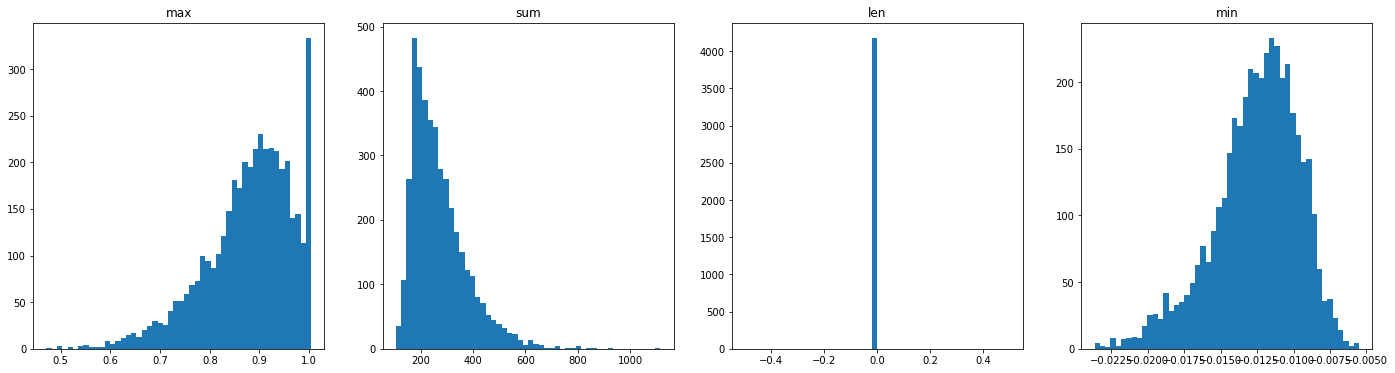

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [11]:
len(syllable_df)

4175

In [12]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(4175, 3392)

In [13]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [14]:
cuml_umap = cumlUMAP()
embedding = cuml_umap.fit_transform(specs_flattened)

In [15]:
np.shape(specs_flattened)

(4175, 3392)

In [16]:
z = embedding

### variation across populations

{"Cuvier's beaked whale": (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), "Gervais's beaked whale": (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}


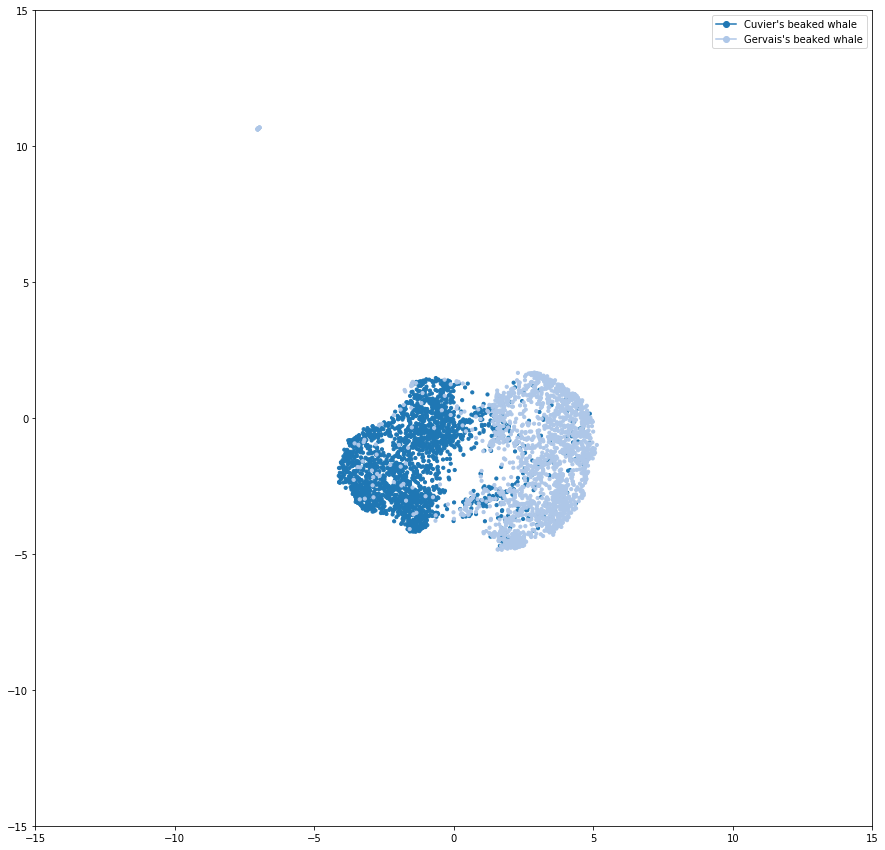

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = syllable_df.common_name.values, s=10, ax = ax)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
plt.show()

In [18]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

{"Cuvier's beaked whale": (0.4, 0.7607843137254902, 0.6470588235294118), "Gervais's beaked whale": (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)}


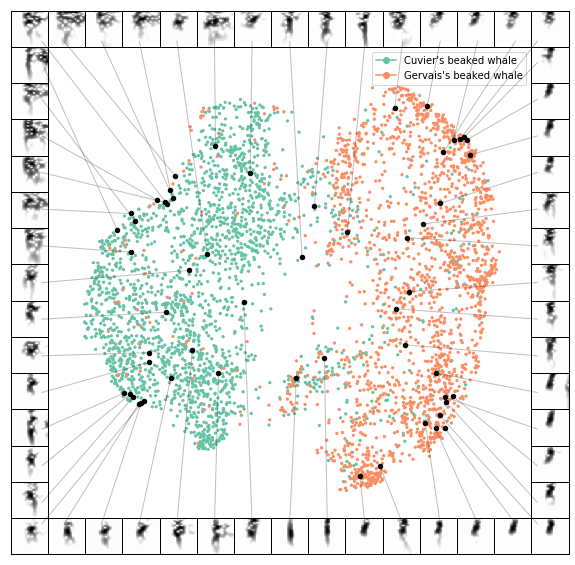

In [19]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [2,11],
    #y_range = [-8,6],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': syllable_df.common_name.values,
        'alpha':1,
        's': 5,
        'show_legend': False,
        'color_palette': 'Set2',
        'show_legend': True

    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURE_DIR / 'hidebrand_beaked_whale', dpi=300, save_jpg=True, save_png=True)

{"Cuvier's beaked whale": (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), "Gervais's beaked whale": (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)}


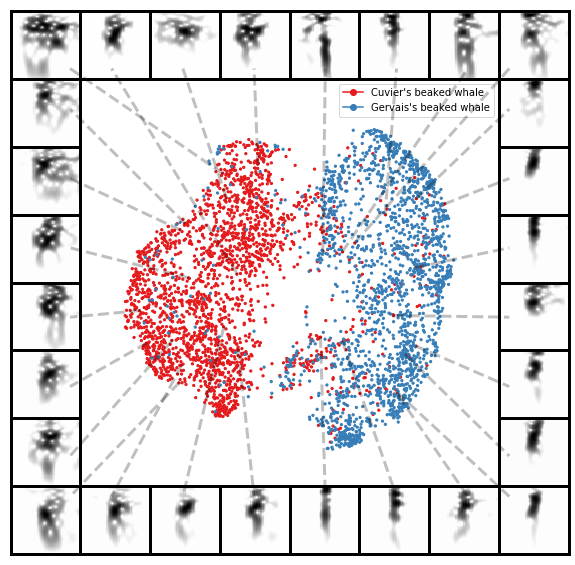

In [20]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': syllable_df.common_name.values,
        'alpha':1,
        's': 5,
        'show_legend': True,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'species' / 'whales', dpi=300, save_jpg=True, save_png=True)

### get silhouette score for each representation

In [22]:
from sklearn.metrics import silhouette_score

In [23]:
score = silhouette_score(list(z), labels = syllable_df.common_name.values)

In [24]:
print(score)

0.40090520581622446


### get silhouette score from spectrum

In [62]:
import scipy.signal

spectrums = np.array([scipy.signal.welch(i)[1] for i in syllable_df.audio.values]);
np.shape(spectrums)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  =

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  =

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  =

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  =

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  =

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  =

(4175, 102)

In [74]:
score = silhouette_score(list(spectrums), labels = syllable_df.common_name.values)

print(score)

0.06609883942801068


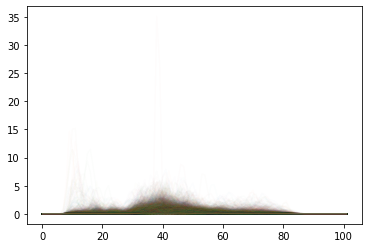

In [63]:
plt.plot(spectrums.T, alpha = 0.01);

In [64]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [65]:
cuml_umap = cumlUMAP()
embedding_spectrum = cuml_umap.fit_transform(spectrums)

In [66]:
np.shape(specs_flattened)

(4175, 3392)

In [67]:
z = embedding_spectrum

### variation across populations

In [71]:
??scatter_projections

{"Cuvier's beaked whale": (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), "Gervais's beaked whale": (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)}


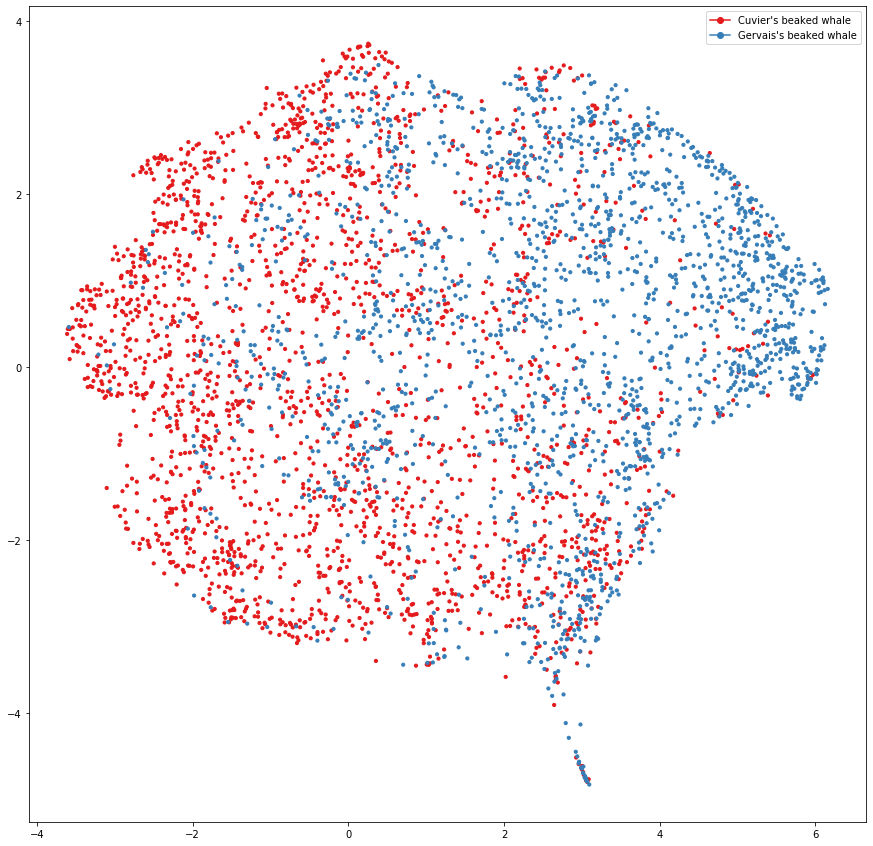

In [73]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = syllable_df.common_name.values, s=10, ax = ax, color_palette = 'Set1')
#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])
plt.show()

In [75]:
score = silhouette_score(list(embedding_spectrum), labels = syllable_df.common_name.values)

In [76]:
print(score)

0.17117305003760788
